## Imports

In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, f1_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

## Load data and train test split

In [2]:
df = pd.read_parquet('../data/cleaned.parquet')
df.shape

(4646773, 23)

Drop unrelevant columns

In [3]:
df = df.drop(columns=['CodeDecision', 'ZIBZIN', 'IDAvisAutorisationCheque'])

Convert date string to datetime

In [4]:
df['DateTransaction'] = pd.to_datetime(
    df['DateTransaction'],
    format="%Y-%m-%d %H:%M:%S",  # correct order
    errors='raise'
)

Split date in year, month, day

In [5]:
df['year'] = df['DateTransaction'].dt.year
df['month'] = df['DateTransaction'].dt.month
df['day'] = df['DateTransaction'].dt.day

Keep data until `2017-08-31` for train, get the rest for test

In [6]:
cutoff = pd.Timestamp("2017-08-31")
mask = df['DateTransaction'] > cutoff

# Drop DateTransaction column
df = df.drop(columns=['DateTransaction'])

train_df = df[~mask].copy()
test_df = df[mask].copy()

In [7]:
print(train_df.shape)
print(test_df.shape)

(3888468, 22)
(758305, 22)


Structure X and y

In [8]:
X_train = train_df.drop(columns=['FlagImpaye'])
X_test = test_df.drop(columns=['FlagImpaye'])

y_train = train_df['FlagImpaye']
y_test = test_df['FlagImpaye']

## Utils functions

In [9]:
def score_threeshold(y_true: np.ndarray|pd.Series, y_proba: np.ndarray) -> tuple[float, float]:
    """
    Plot f1-score in function of threeshold values

    Args:
        y_true (np.ndarray | pd.Series): Ground truth Y values
        y_proba (np.ndarray): Predicted Y values

    Return:
        float: Threeshold value that max the f1-score
        float: Corresponding maxed f1-score
    """
    score = y_proba[:,1]
    pos = pd.get_dummies(y_true).iloc[:,1].values

    # Count of positive and sort
    npos = np.sum(pos)
    index = np.flip(np.argsort(score))

    # Compute recall, precision and f1-score
    rappel = np.cumsum(pos[index]) / npos
    precision = np.cumsum(pos[index]) / np.arange(start=1, stop=score.shape[0]+1, step=1)
    f1 = 2.0 * (precision * rappel) / (precision + rappel)
    f1[np.isnan(f1)] = 0

    # Plot
    plt.xlabel('Score - P(Y = + / X)')
    plt.ylabel('F1-Score')
    plt.plot(score[index], f1)
    plt.show()

    # Compute best threeshold and corresponding f1-score
    id_max = np.argmax(f1)
    best_threeshold = score[index][id_max]
    best_score = f1[id_max]
    return best_threeshold, best_score

## Simple Random Forest

In [52]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [53]:
y_pred = rf_clf.predict(X_test)

Let's see how the random forest performs

In [58]:
f1_score(y_test, y_pred, pos_label=1)

0.04722773212430339

It is really low, let's check the distribution of the predicted probabilities

In [61]:
y_proba = rf_clf.predict_proba(X_test)

{'whiskers': [<matplotlib.lines.Line2D at 0x3344d6f10>,
 'caps': [<matplotlib.lines.Line2D at 0x3344e4410>,
 'boxes': [<matplotlib.lines.Line2D at 0x3344d6610>],
 'medians': [<matplotlib.lines.Line2D at 0x3344e5510>],
 'fliers': [<matplotlib.lines.Line2D at 0x3344e5d50>],
 'means': []}

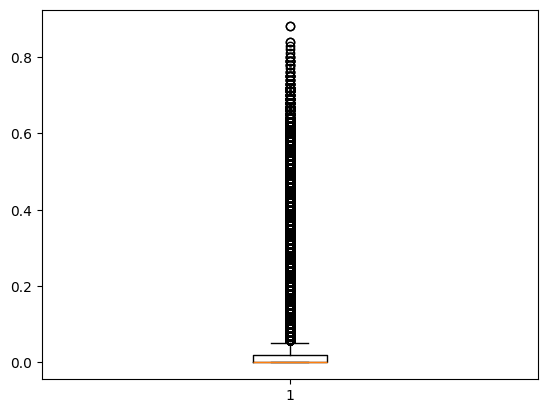

In [65]:
plt.boxplot(y_proba[:,1])

In [ ]:
print('Mean:', y_proba.mean(axis=0))
print('Median:', np.median(y_proba, axis=0))

mean proba: [0.95280209 0.04719791]
median proba: [1. 0.]


As we can see on this boxplot, the distribution of the probabilities are not good at all. The're all condensed in low values (mean of 0.05) and should be recalibrated. 

We can check the aera under the roc curve to get a better idea of the actual model performance

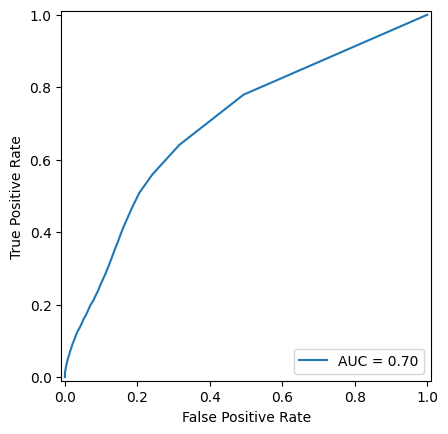

In [70]:
fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc
).plot()

Let's now check the evolution of f1-score depending on affection threeshold

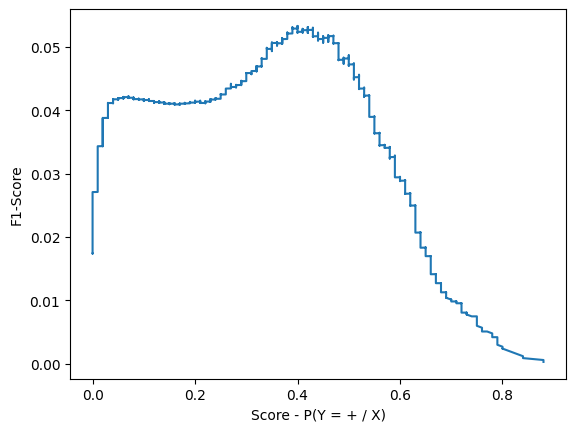

In [82]:
best_threeshold, best_score = score_threeshold(y_test, y_proba)

In [83]:
print('Best threeshold:', best_threeshold)
print('Best score:', best_score)

Best threeshold: 0.4
Best score: 0.053287260161862325


Calibrating the affectation threeshold only slightly improved the f1-score. The model score still is not the best we can get. Let's try other models before tuning the hyper parameters

## SVM

We will now use a Soft Margin Vector classifier with a rbf kernel

In [12]:
svm_clf = SVC(verbose=True)
svm_clf.fit(X_train, y_train)

[LibSVM]........................
*...
*
optimization finished, #iter = 27270
obj = -46692.169175, rho = -0.999673
nSV = 47076, nBSV = 46598
Total nSV = 47076


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",True


Check the performance

In [13]:
y_pred = svm_clf.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, pos_label=1)

In [ ]:
y_proba = rf_clf.predict_proba(X_test)

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc
).plot()

## Gradient Boosting (XGBoost)

Ensemble models like Gradient Boosting can highly improve the performance of a random forest in a imbalanced context

Validation set (20% validation, 80% train)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train
)

In [15]:
xgb_clf = XGBClassifier(
    tree_method="hist",
    objective='binary:logistic',
    early_stopping_rounds=50,
    n_jobs=-1
)

xgb_clf.fit(
    X_train, 
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=True
)

[0]	validation_0-logloss:0.03766
[1]	validation_0-logloss:0.03625
[2]	validation_0-logloss:0.03528
[3]	validation_0-logloss:0.03451
[4]	validation_0-logloss:0.03403
[5]	validation_0-logloss:0.03377
[6]	validation_0-logloss:0.03353
[7]	validation_0-logloss:0.03307
[8]	validation_0-logloss:0.03290
[9]	validation_0-logloss:0.03278
[10]	validation_0-logloss:0.03254
[11]	validation_0-logloss:0.03241
[12]	validation_0-logloss:0.03229
[13]	validation_0-logloss:0.03223
[14]	validation_0-logloss:0.03208
[15]	validation_0-logloss:0.03159
[16]	validation_0-logloss:0.03151
[17]	validation_0-logloss:0.03138
[18]	validation_0-logloss:0.03129
[19]	validation_0-logloss:0.03116
[20]	validation_0-logloss:0.03109
[21]	validation_0-logloss:0.03107
[22]	validation_0-logloss:0.03096
[23]	validation_0-logloss:0.03091
[24]	validation_0-logloss:0.03082
[25]	validation_0-logloss:0.03077
[26]	validation_0-logloss:0.03067
[27]	validation_0-logloss:0.03065
[28]	validation_0-logloss:0.03063
[29]	validation_0-loglos

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [16]:
y_pred = xgb_clf.predict(X_test)

In [17]:
f1_score(y_test, y_pred, pos_label=1)

0.0858246001103144

In [19]:
y_proba = xgb_clf.predict_proba(X_test)

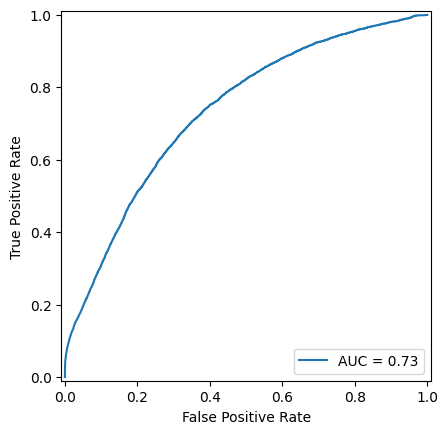

In [20]:
fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc
).plot()

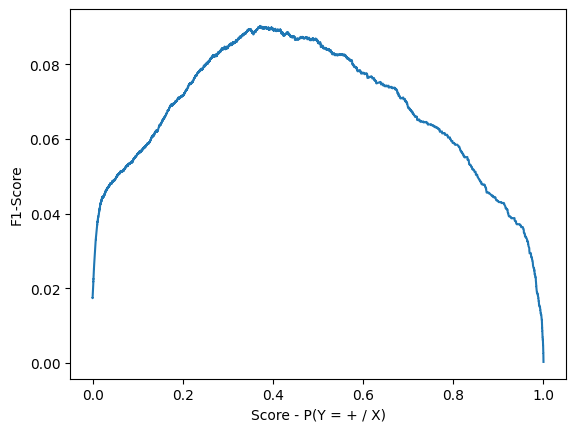

In [21]:
best_threeshold, best_score = score_threeshold(y_test, y_proba)

In [22]:
best_score

np.float64(0.09030837004405286)

It is a good score compared to previous models. Let's try to fine tune it

In [31]:
# 1. Compute class weight for imbalance

positive_count = y_train.sum()
negative_count = len(y_train) - y_train.sum()

scale_weight = negative_count/positive_count
scale_weight

np.float64(165.55640627509771)

In [32]:
# 2. Define parameter grid

param_grid = {
    "n_estimators": [400, 800],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "reg_lambda": [1.0, 5.0],
}

In [33]:
# 3. Cross-validation object

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
# 4. Grid search configured to maximize ROC-AUC (prevent bad f1-score threeshold from affecting the model)

xgb = XGBClassifier(
    tree_method="hist",
    objective="binary:logistic",
    scale_pos_weight=scale_weight,
    eval_metric="auc",
    n_jobs=-1
)

In [36]:
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/marinnagy/Documents/GitHub/Bank-Imbalanced/imbalanced-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'colsample_bytree': [0.7, 0.9], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'n_estimators': [400, 800], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation tim

In [37]:
print("Best ROC-AUC:", grid.best_score_)
print("Best params:", grid.best_params_)

Best ROC-AUC: 0.8666751015202964
Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 800, 'reg_lambda': 5.0, 'subsample': 0.9}


In [38]:
y_pred = grid.best_estimator_.predict(X_test)
f1_score(y_test, y_pred, pos_label=1)

0.035344979967004475

The model is worst than the default version. Maybe bad threeshold, maybe overfitted? We can check its AUC score

In [39]:
y_proba = grid.best_estimator_.predict_proba(X_test)

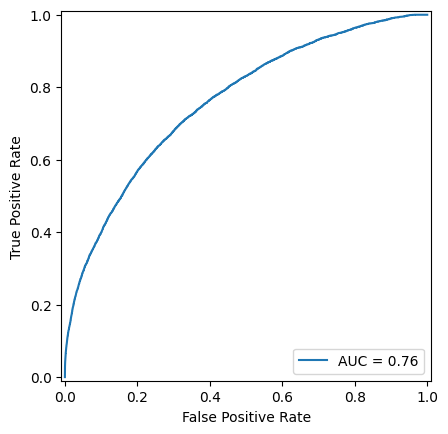

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc
).plot()

The ROC curve looks promessing, lets see it's f1-score on different threesholds

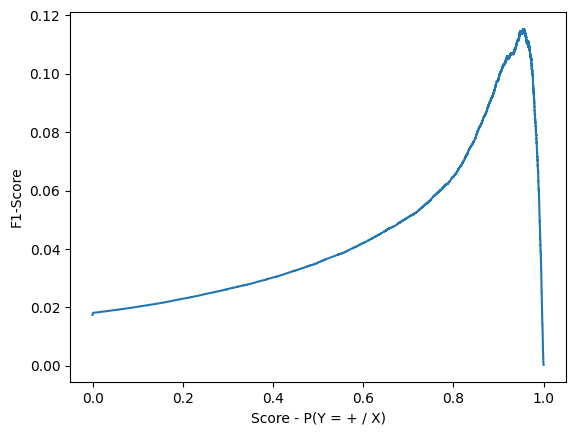

In [41]:
best_threeshold, best_score = score_threeshold(y_test, y_proba)

In [42]:
print('Best threeshold:', best_threeshold)
print('Best score:', best_score)

Best threeshold: 0.9560325
Best score: 0.11533953270297727


Interesting! While previous models tend to make low predictions, this one over estimate the score and thus the trheeshold needs to be increased at about 0.95 to reach a f1-score of 0.11. Maybe we added too much weight on our minotary class with `scale_pos_weight`. Let's try to use the same params with half of the weight

In [44]:
best_params = grid.best_params_.copy()  # Copy best params from grid search
best_params["scale_pos_weight"] = scale_weight/2

xgb_clf_2 = XGBClassifier(
    **best_params,
    tree_method="hist",
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1
)

xgb_clf_2.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

Compare AUC score

In [48]:
y_proba = xgb_clf_2.predict_proba(X_test)

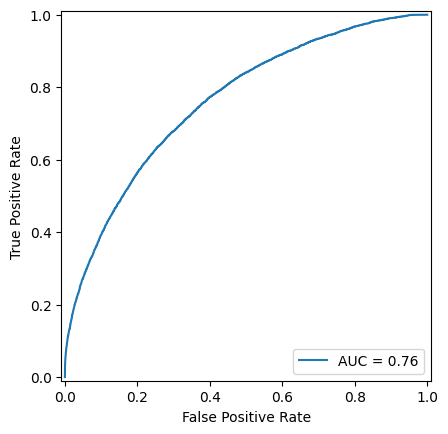

In [49]:
fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc
).plot()

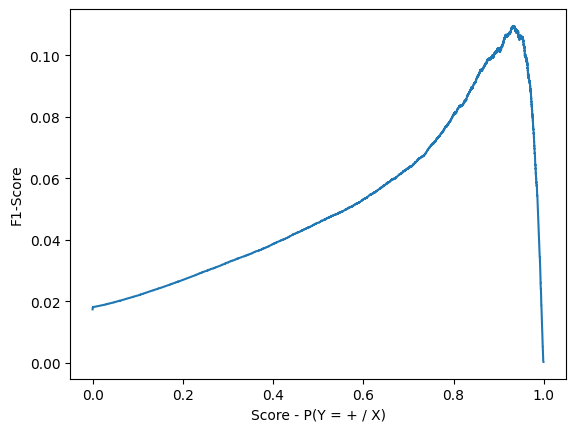

In [50]:
best_threeshold, best_score = score_threeshold(y_test, y_proba)

The curve is a bit smoother but ideal threeshold is about the same. I want to investigate to find out why is it so different from original XGBoost

Let's try to disable class weight

In [59]:
best_params['scale_pos_weight'] = None

xgb_clf_3 = XGBClassifier(
    **best_params,
    tree_method="hist",
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1,
)

xgb_clf_3.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [60]:
y_proba = xgb_clf_3.predict_proba(X_test)

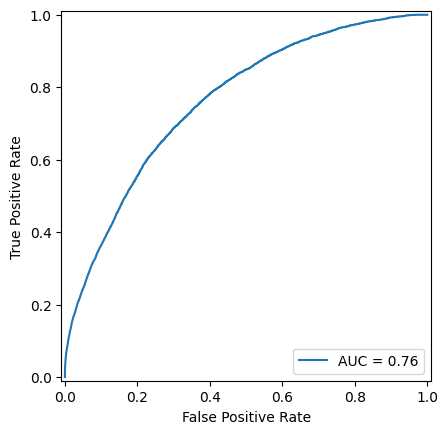

In [61]:
fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc
).plot()

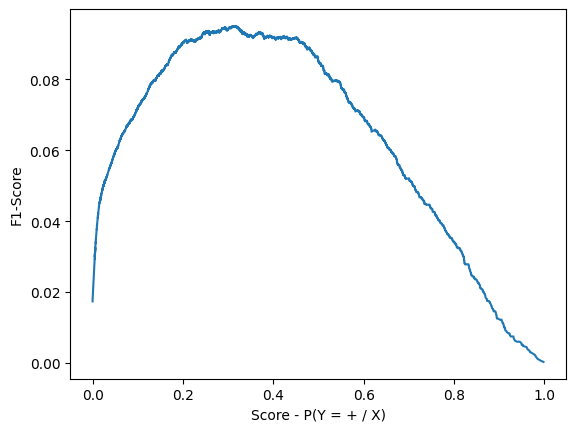

In [62]:
best_threeshold, best_score = score_threeshold(y_test, y_proba)

The threeshold is now calibrated around 0.4 but the max f1-score is not as good

## Sampling